# Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

## Introduction to the Data Set

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bike_rentals = pd.read_csv('bike_rental_hour.csv')


In [15]:
bike_rentals.shape

(17379, 17)

In [16]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Histogram

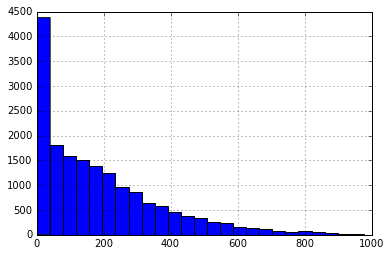

In [14]:
bike_rentals['cnt'].hist(bins = 25)

From the histogram above that we can tell that 0~25 times of rental is most common. However, we have to consider that the bike rentals probably have seasonality. 

### Correation

In [25]:
np.abs(bike_rentals.corr()['cnt']).sort_values(ascending = False).drop('cnt')

registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

The correlation table says that registered and casual columns have the most correlation with count. The result is unsurprising because if you add registered and casual column you get the cnt. Other than ***that, temp, atemp, and hum*** correlate to ***cnt*** column. 

## Calculating Features

### Assigning Lables

One of the most correlated columns to ***cnt*** is hr. It's reasonable to think that people rent bike in different time frames. For instance, more people rent bikes during the day than they do during the night. Let's aggregate the hours in to 4 different time frames of a day. 

- 1 if the hour is from 6 to 12
- 2 if the hour is from 12 to 18
- 3 if the hour is from 18 to 24
- 4 if the hour is from 0 to 6

In [56]:
def assign_label(hr):
    if (hr >= 6) & (hr < 12):
        return 1
    elif (hr >= 12) & (hr < 18):
        return 2
    elif (hr >= 18) & (hr < 24):
        return 3
    elif (hr >= 0) & (hr < 6):
        return 4

In [58]:
bike_rentals['time_label'] =bike_rentals['hr'].apply(assign_label)

## Splitting the Data into Train and Test Sets

The problem itself is a lot like linear regression problem. We are going to use Root Mean Squeared Error as our evaluation method because it's a relatively simple and intuitive metric. It's also easy to understand the result. 

For the evaluation, we are going to use the holdout method.

It's also worth mentioning that the evaluation method and metric are subject to change as the model develops.

In [72]:
# Use random_state parameter for the reproducible result.
train = bike_rentals.sample(int(len(bike_rentals)*0.8), random_state = 1)

# Assign the rest to the test set. 
test = bike_rentals[~bike_rentals.index.isin(train.index)]

## Applying Linear Regression

As mentioned before, the problem looks like it has some linearlity. We are going to apply the linear regression to predict.

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

We are ignoring casual and registered columns because cnt column is derived from them. 

For the starter, we are going to include all columns except casual, dteday, and registered columns using the default hyper parameters. 

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [92]:
columns = train.columns
drop_columns = ['cnt','casual','dteday','registered']
features = columns.drop(drop_columns)
target = 'cnt'

In [188]:
def lr_train_and_test(train, test, features, target):
    model = LinearRegression()
    model.fit(train[features], train[target])
    
    # train and test prediction to see if the model is overfitting or underfitting.
    predictions = model.predict(test[features])
    train_predictions = model.predict(train[features])
    
    # Applying error metrics
    mse = mean_squared_error(test[target], predictions)
    train_mse = mean_squared_error(train[target], train_predictions)
    rmse = mse**(1/2)
    train_rmse = train_mse**(1/2)
    return rmse, train_rmse

In [189]:
"test_rmse:{}, train_rmse:{}".format(lr_train_and_test(train, test, features, target)[0], lr_train_and_test(train, test, features, target)[1])

'test_rmse:130.5837848710458, train_rmse:132.6074938336205'

In [95]:
bike_rentals['cnt'].std()

181.38759909186473

With the default linear regression we got 130.58 as the error. Which doesn't seem to be very impressive, but not bad either considering that the standard deviation is 181.39. 

The model doesn't seem to be overfitting either. There is only small difference in the test and train RMSE.

Let's try other algorithm.

## Applying Decision Trees

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [186]:
from sklearn.tree import DecisionTreeRegressor

def dt_train_and_test(train, test, features, target):
    model = DecisionTreeRegressor()
    model.fit(train[features], train[target])
    
    # train and test prediction to see if the model is overfitting or underfitting.
    predictions = model.predict(test[features])
    train_predictions = model.predict(train[features])
    
    # Applying error metrics
    mse = mean_squared_error(test[target], predictions)
    train_mse = mean_squared_error(train[target], train_predictions)
    rmse = mse**(1/2)
    train_rmse = train_mse**(1/2)
    return rmse, train_rmse

In [187]:
"test_rmse:{}, train_rmse:{}".format(dt_train_and_test(train, test, features, target)[0], dt_train_and_test(train, test, features, target)[1])

'test_rmse:57.40675633745188, train_rmse:0.0'

The model improved compare to linear regression. However, it came back with train RMSE as 0. Which means, the model is probably overfitting. Let's tweak around hyper parameter and see if that solves the overfitting problem.

### Pruning (Max Depth)

In [183]:
from sklearn.tree import DecisionTreeRegressor

def dt_train_and_test(train, test, features, target, max_depth = 10):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(train[features], train[target])
    
    # train and test prediction to see if the model is overfitting or underfitting.
    predictions = model.predict(test[features])
    train_predictions = model.predict(train[features])
    
    # Applying error metrics
    mse = mean_squared_error(test[target], predictions)
    train_mse = mean_squared_error(train[target], train_predictions)
    rmse = mse**(1/2)
    train_rmse = train_mse**(1/2)
    return rmse, train_rmse

In [184]:
"test_rmse:{}, train_rmse:{}".format(dt_train_and_test(train, test, features, target)[0], dt_train_and_test(train, test, features, target)[1])

'test_rmse:61.33490195936137, train_rmse:48.38933791987952'

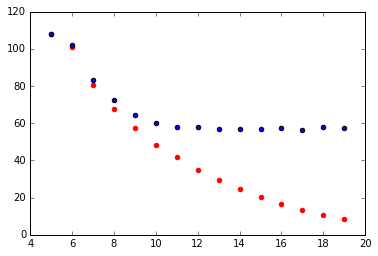

In [185]:
train_rmses = {}
test_rmses = {}

for depth in range(5, 20):
    rmse = dt_train_and_test(train,test,features,target, max_depth= depth)
    train_rmses[depth] = rmse[1]
    test_rmses[depth] = rmse[0]

plt.scatter(x=list(train_rmses.keys()), y = list(train_rmses.values()), color = 'red')
plt.scatter(x=list(test_rmses.keys()), y = list(test_rmses.values()))

From the graph above, the overfitting starts when the depth is past 8. The model is improving until around max_depth is 11 however. After that it stops improving and continuing to overfit. Let's see if adjusting model complexity helps it with the overfitting. 

### Model Complexity

Now that we know the model continues to improve until max depth 11, let's see if adjusting min_samples_leaf helps the model.

In [180]:
from sklearn.tree import DecisionTreeRegressor

def dt_train_and_test(train, test, features, target, max_depth = 11, min_samples_leaf = 50):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
    model.fit(train[features], train[target])
    
    # train and test prediction to see if the model is overfitting or underfitting.
    predictions = model.predict(test[features])
    train_predictions = model.predict(train[features])
    
    # Applying error metrics
    mse = mean_squared_error(test[target], predictions)
    train_mse = mean_squared_error(train[target], train_predictions)
    rmse = mse**(1/2)
    train_rmse = train_mse**(1/2)
    return rmse, train_rmse


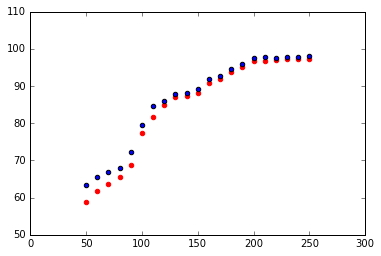

In [181]:
train_rmses = {}
test_rmses = {}

for leaf in range(250, 40, -10):
    rmse = dt_train_and_test(train,test,features,target, max_depth= depth, min_samples_leaf = leaf)
    train_rmses[leaf] = rmse[1]
    test_rmses[leaf] = rmse[0]

plt.scatter(x=list(train_rmses.keys()), y = list(train_rmses.values()), color = 'red')
plt.scatter(x=list(test_rmses.keys()), y = list(test_rmses.values()))

In [182]:
train_rmses

{50: 58.729744722753466,
 60: 61.65846154849201,
 70: 63.61730124618192,
 80: 65.51887140283515,
 90: 68.72965062805096,
 100: 77.48274721898115,
 110: 81.59362953809335,
 120: 85.01897880995158,
 130: 87.11209375172488,
 140: 87.41362515217008,
 150: 88.22834634268172,
 160: 90.83752317606898,
 170: 91.87394858337339,
 180: 93.86562011642614,
 190: 95.15037713718431,
 200: 96.70557498050786,
 210: 96.8491404977466,
 220: 96.8848961538293,
 230: 97.19985148683125,
 240: 97.23959262275721,
 250: 97.245033101717}

By reducing the min_samples_leaf, we brought up train error to 58.64 without hurting the test error. The model is now less overfitting. 

### Applying Random Forests

Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [195]:
from sklearn.ensemble import RandomForestRegressor

## Training with the basic model.

def rf_train_and_test(train, test, features, target):
    model = RandomForestRegressor()
    model.fit(train[features], train[target])
    
    # train and test prediction to see if the model is overfitting or underfitting.
    predictions = model.predict(test[features])
    train_predictions = model.predict(train[features])
    
    # Applying error metrics
    mse = mean_squared_error(test[target], predictions)
    train_mse = mean_squared_error(train[target], train_predictions)
    rmse = mse**(1/2)
    train_rmse = train_mse**(1/2)
    return rmse, train_rmse

"test_rmse:{}, train_rmse:{}".format(rf_train_and_test(train, test, features, target)[0], rf_train_and_test(train, test, features, target)[1])

'test_rmse:44.58302820482861, train_rmse:18.502247910224987'

The model has improved. However it seems it's overfitting. Let's apply the same approach as before.

### Pruning

In [198]:
from sklearn.ensemble import RandomForestRegressor

## Training with the basic model.

def rf_train_and_test(train, test, features, target, max_depth = 5):
    model = RandomForestRegressor(max_depth = max_depth)
    model.fit(train[features], train[target])
    
    # train and test prediction to see if the model is overfitting or underfitting.
    predictions = model.predict(test[features])
    train_predictions = model.predict(train[features])
    
    # Applying error metrics
    mse = mean_squared_error(test[target], predictions)
    train_mse = mean_squared_error(train[target], train_predictions)
    rmse = mse**(1/2)
    train_rmse = train_mse**(1/2)
    return rmse, train_rmse

"test_rmse:{}, train_rmse:{}".format(rf_train_and_test(train, test, features, target)[0], rf_train_and_test(train, test, features, target)[1])

'test_rmse:106.38829515762869, train_rmse:105.95194963762667'

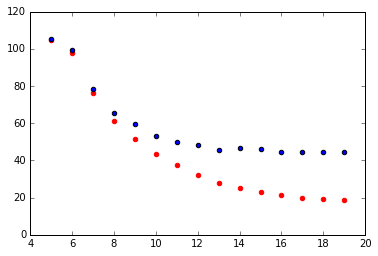

In [199]:
train_rmses = {}
test_rmses = {}

for depth in range(5, 20):
    rmse = rf_train_and_test(train,test,features,target, max_depth= depth)
    train_rmses[depth] = rmse[1]
    test_rmses[depth] = rmse[0]

plt.scatter(x=list(train_rmses.keys()), y = list(train_rmses.values()), color = 'red')
plt.scatter(x=list(test_rmses.keys()), y = list(test_rmses.values()))

The models doesn't seem to be impoved. 

### Complexity

In [225]:
from sklearn.ensemble import RandomForestRegressor

## Training with the basic model.

def rf_train_and_test(train, test, features, target, min_samples_leaf = 10):
    model = RandomForestRegressor( min_samples_leaf = min_samples_leaf)
    model.fit(train[features], train[target])
    
    # train and test prediction to see if the model is overfitting or underfitting.
    predictions = model.predict(test[features])
    train_predictions = model.predict(train[features])
    
    # Applying error metrics
    mse = mean_squared_error(test[target], predictions)
    train_mse = mean_squared_error(train[target], train_predictions)
    rmse = mse**(1/2)
    train_rmse = train_mse**(1/2)
    return rmse, train_rmse

"test_rmse:{}, train_rmse:{}".format(rf_train_and_test(train, test, features, target)[0], rf_train_and_test(train, test, features, target)[1])

'test_rmse:49.30636249871798, train_rmse:39.81736522879251'

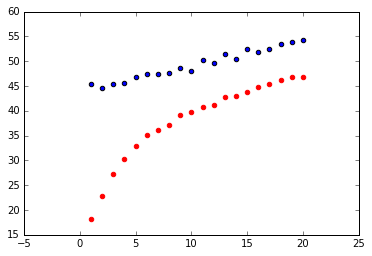

In [227]:
train_rmses = {}
test_rmses = {}

for leaf in range(20, 0,-1):
    rmse = rf_train_and_test(train,test,features,target, min_samples_leaf = leaf)
    train_rmses[leaf] = rmse[1]
    test_rmses[leaf] = rmse[0]

plt.scatter(x=list(train_rmses.keys()), y = list(train_rmses.values()), color = 'red')
plt.scatter(x=list(test_rmses.keys()), y = list(test_rmses.values()))

The error slightly increased, but the model is generalizing better. 

### n_estimator

In [228]:
from sklearn.ensemble import RandomForestRegressor

## Training with the basic model.

def rf_train_and_test(train, test, features, target, min_samples_leaf= 8, n_estimators = 10):
    model = RandomForestRegressor(min_samples_leaf = min_samples_leaf, n_estimators= n_estimators)
    model.fit(train[features], train[target])
    
    # train and test prediction to see if the model is overfitting or underfitting.
    predictions = model.predict(test[features])
    train_predictions = model.predict(train[features])
    
    # Applying error metrics
    mse = mean_squared_error(test[target], predictions)
    train_mse = mean_squared_error(train[target], train_predictions)
    rmse = mse**(1/2)
    train_rmse = train_mse**(1/2)
    return rmse, train_rmse

"test_rmse:{}, train_rmse:{}".format(rf_train_and_test(train, test, features, target)[0], rf_train_and_test(train, test, features, target)[1])

'test_rmse:48.19122585273032, train_rmse:37.21658770640586'

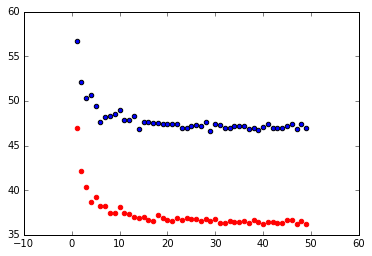

In [229]:
train_rmses = {}
test_rmses = {}

for n in range(1, 50):
    rmse = rf_train_and_test(train,test,features,target,n_estimators=n)
    train_rmses[n] = rmse[1]
    test_rmses[n] = rmse[0]

plt.scatter(x=list(train_rmses.keys()), y = list(train_rmses.values()), color = 'red')
plt.scatter(x=list(test_rmses.keys()), y = list(test_rmses.values()))

## Conclusion

We explored, the bike rentals prediction with difference models. 